# 우회전 유스케이스 분석

![description](imgs/image_RT.png)

In [5]:
# 상태에 min_spacing등만 넣을게 아니라, min2_spacing 등 추가
# state 변경 8개
#     """
#     State Vector (예시: 13차원)
#     0:  ego_speed           (0~1, 50 km/h 기준 정규화)
#     1:  dtc_norm            (0~1, 충돌지점까지 남은 거리 / 200 m)
#     2:  time_to_Gn_norm     (0~1, GN까지 남은 시간 / 100 s)
#     3:  f1_spacing_norm     (0~1, 가장 가까운 following spacing)
#     4:  f1_ttc_norm         (0~1, 가장 가까운 following TTC)
#     5:  f1_rel_speed_norm   (~[-1,1], 가장 가까운 following 상대속도)
#     6:  f2_spacing_norm     (0~1, 두 번째 following spacing)
#     7:  f2_ttc_norm         (0~1, 두 번째 following TTC)
#     8:  c1_spacing_norm     (0~1, 가장 가까운 crossing spacing)
#     9:  c1_pet_norm         (0~1, 가장 가까운 crossing PET)
#     10: c2_spacing_norm     (0~1, 두 번째 crossing spacing)
#     11: c2_pet_norm         (0~1, 두 번째 crossing PET)
#     12: dummy_cross_rel     (~[-1,1], crossing 상대속도 자리(현재 0.0, 추후 확장용))
#     """
    
# 앞뒤차 4대


In [6]:
"""
VISSIM TD3 Template for Single-Ego Accel Control at Signalized Intersection
- Author: Kawon Kang
- Purpose: Single vehicle (ego) continuous accel guidance via TD3
- Control: action a_t [m/s^2] -> target desired speed (DesSpeed) for ego
- Safety layer + yellow dilemma rule as post-processing on action
"""

# basic libraries
import os
import sys
import random
import math
import time
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional

# VISSIM COM
import win32com.client as COM

# data libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False


# -----------------------------
# PyTorch 기반 TD3
# -----------------------------

import torch
import torch.nn as nn
import torch.optim as optim


from collections import deque, defaultdict

# 재현성
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



PPO, DDPG, TD3 모델

In [7]:
# =========================
# VISSIM 유틸 (원본 최대 유지)
# =========================
def is_vehicle_valid(vehicle):
    try:
        vehicle.AttValue('No')
        vehicle.AttValue('Speed')
        vehicle.AttValue('Pos')
        return True
    except:
        return False

def get_valid_vehicles(Vissim):
    try:
        vehicles = []
        for vehicle in Vissim.Net.Vehicles:
            try:
                vehicle_no = vehicle.AttValue('No')
                vehicle_pos = vehicle.AttValue('Pos')
                vehicle_speed = vehicle.AttValue('Speed')
                vehicle_link = vehicle.AttValue('Lane')
                if all(attr is not None for attr in [vehicle_no, vehicle_pos, vehicle_speed, vehicle_link]):
                    vehicles.append(vehicle)
            except:
                continue
        return vehicles
    except Exception as e:
        print(f"Error in get_valid_vehicles: {str(e)}")
        return []
def reset_network(Vissim):
        # try:
    Vissim.Simulation.Stop()
    try:
        for vehicle in list(Vissim.Net.Vehicles):
            try:
                Vissim.Net.Vehicles.RemoveVehicle(vehicle.AttValue('No'))
            except:
                continue
    except:
        pass
def create_vehicles(Vissim, link_ranges):
    # try:
    Vissim.Simulation.Stop()
    try:
        for vehicle in list(Vissim.Net.Vehicles):
            try:
                Vissim.Net.Vehicles.RemoveVehicle(vehicle.AttValue('No'))
            except:
                continue
    except:
        pass
    time.sleep(0.2)
    cv_rand = np.random.randint(1, 100)
    Vissim.Simulation.SetAttValue('RandSeed', cv_rand)
    Vissim.Simulation.RunSingleStep()

    for _ in range(np.random.randint(850,1000)): # 80~ 100초까지 warm-up 100초에 남직신호 시작
        Vissim.Simulation.RunSingleStep()
    
    created_vehicles = []
    regular_vehicles = [
        (11, link_ranges[1][0], link_ranges[1][1], 1), # link, start_pos, end_pos, veh_num
        (11, link_ranges[2][0], link_ranges[2][1], 2), 
        (11, link_ranges[3][0], link_ranges[3][1], 3),
        (11, link_ranges[4][0], link_ranges[4][1], 4)
    ]
    for link, start_pos, end_pos, veh_num in regular_vehicles:
        vehicle = Vissim.Net.Vehicles.AddVehicleAtLinkPosition( #주변 차량 생성
            100, link, (veh_num+1)//2 , np.random.uniform(start_pos, end_pos), 40, True #Type, Lane, Pos, DesSpeed, Interaction(Opt)-> 주변객체 상호작용 여부
        )
        if vehicle:
            vehicle.SetAttValue('DesSpeed', 40) # 물어보기
            # vehicle.SetAttValue('DesLane', random.choice([1,2])) # 조정필요
            created_vehicles.append(vehicle)
            time.sleep(0.1)

    ego_pos = np.random.uniform(50, 60) # 조정필요
    ego_vehicle = Vissim.Net.Vehicles.AddVehicleAtLinkPosition(
        630, 11, np.random.choice([1,2]), ego_pos, 50, True 
    )
    if ego_vehicle:
        ego_vehicle.SetAttValue('DesSpeed', 50)
        ego_vehicle.SetAttValue('DesLane', 1) # 우회전만 하라.
        created_vehicles.append(ego_vehicle)
        time.sleep(0.2)

    # follower_pos = ego_pos - 30
    # if follower_pos >= link_ranges[3][0]:
    #     follower = Vissim.Net.Vehicles.AddVehicleAtLinkPosition(
    #         100, 3, 1, follower_pos, 40, True 
    #     )
    #     if follower:
    #         follower.SetAttValue('DesSpeed', 50)
    #         created_vehicles.append(follower)

    if len(created_vehicles) > 3:
        time.sleep(0.2)
        Vissim.Simulation.RunSingleStep()
        return created_vehicles
    return None
    # except Exception as e:
    #     print(f"Error in create_vehicles: {str(e)}")
    #     return None

In [8]:

LINK_LENGTHS = {
    "11-1": 149.4,
    "11-2": 149.4,
    "10002-1": 39.76,
    "4-1": 18.22,
    "9-1": 160.03,
    "10009-1": 40.89,
    "7-1": 200.0  # 필요 시 실제 길이로 수정
}

def get_dist_to_conflict(link_id, pos, role="ego"):
    """상충 지점까지의 남은 거리(DTC) 계산"""
    dtc = 1000.0
    try:
        link_id = str(link_id)
        if role == "ego":
            if link_id in ["11-1", "11-2"]:
                dtc = (LINK_LENGTHS["11-1"] - pos) + LINK_LENGTHS["10002-1"] + LINK_LENGTHS["4-1"]
            elif link_id == "10002-1":
                dtc = (LINK_LENGTHS["10002-1"] - pos) + LINK_LENGTHS["4-1"]
            elif link_id == "4-1":
                dtc = (LINK_LENGTHS["4-1"] - pos)
            elif link_id == "7-1":
                dtc = -pos
        elif role == "other":
            if link_id == "9-1":
                dtc = (LINK_LENGTHS["9-1"] - pos) + LINK_LENGTHS["10009-1"]
            elif link_id == "10009-1":
                dtc = (LINK_LENGTHS["10009-1"] - pos)
            elif link_id == "7-1":
                dtc = -pos
    except:
        pass
    return dtc

def calculate_observations(vehicle_list, ego_num=5):
    """
    모든 차량에 대해 Spacing과 시간지표(TTC/PET)를 계산.
    obs_dict[key] = {
        'type': 'following' or 'crossing',
        'spacing': ...,
        'ttc': ... (following),
        'pet': ... (crossing),
        ...
    }
    """
    obs_dict = {}
    ego_vehicle = None
    
    # Ego 찾기
    for vehicle in vehicle_list:
        if vehicle.AttValue('No') == ego_num:
            ego_vehicle = vehicle
            break
    if not ego_vehicle:
        return obs_dict

    ego_link = str(ego_vehicle.AttValue('Lane'))
    ego_pos  = float(ego_vehicle.AttValue('Pos'))
    ego_speed = float(ego_vehicle.AttValue('Speed') or 0) / 3.6
    dtc_ego = get_dist_to_conflict(ego_link, ego_pos, role="ego")

    crossing_target_links = ["9-1", "10009-1"]

    for other_vehicle in vehicle_list:
        oid = other_vehicle.AttValue('No')
        if oid == ego_num:
            continue

        other_link = str(other_vehicle.AttValue('Lane'))
        other_pos = float(other_vehicle.AttValue('Pos'))
        other_speed = float(other_vehicle.AttValue('Speed') or 0) / 3.6
        
        # 1) 같은 차선: following
        if ego_link == other_link and other_pos > ego_pos:
            spacing = other_pos - ego_pos
            rel_speed = ego_speed - other_speed
            ttc = spacing / (rel_speed + 1e-6) if rel_speed > 0 else 100.0

            if spacing < 60:
                obs_dict[f"{ego_num}_{oid}"] = {
                    "type": "following",
                    "spacing": spacing,
                    "ttc": ttc,
                    "rel_speed": rel_speed
                }

        # 2) 교차 차선: crossing
        elif (other_link in crossing_target_links) and (dtc_ego > -5):
            dtc_other = get_dist_to_conflict(other_link, other_pos, role="other")
            if dtc_other > -5:
                spacing = max(0, dtc_ego) + max(0, dtc_other)
                tta_ego = dtc_ego / max(ego_speed, 0.1)
                tta_other = dtc_other / max(other_speed, 0.1)
                pet = abs(tta_ego - tta_other)

                if tta_ego < 20:
                    obs_dict[f"{ego_num}_{oid}"] = {
                        "type": "crossing",
                        "spacing": spacing,
                        "pet": pet,
                        "tta_ego": tta_ego,
                        "tta_other": tta_other
                    }

    return obs_dict


def get_reward(vehicle, obs_dict):
    if vehicle is None: return 0.0, False
    
    reward = 0.1 # 생존 보상
    done = False
    
    # 가장 위험한 값 추출 (Spacing도 보고, 시간도 봄)
    min_spacing = 1000.0
    min_time_metric = 1000.0 # TTC or PET
    
    for _, data in obs_dict.items():
        # 거리 갱신 (무조건 가까우면 장땡)
        if data['spacing'] < min_spacing:
            min_spacing = data['spacing']
        
        # 시간 갱신 (유형별로 위험도 판단)
        if data['type'] == 'following':
            if data['ttc'] < min_time_metric: min_time_metric = data['ttc']
        elif data['type'] == 'crossing':
            if data['pet'] < min_time_metric: min_time_metric = data['pet']

    # --------------------------------------------------------
    # [보상 로직] Spacing과 Time Metric을 모두 사용
    # --------------------------------------------------------
    
    # 1. Spacing 기반 (물리적 충돌 방지 - 최우선)
    if min_spacing < 2.0: # 쾅!
        reward -= 200
        return float(reward), True # 종료
    elif min_spacing < 5.0: # 너무 가깝다
        reward -= 10
    elif min_spacing < 10.0: # 불안하다
        reward -= 2

    # 2. Time 기반 (예측 위험 회피)
    # 거리가 좀 있어도(20m), 속도가 빨라서 TTC/PET가 1초면 위험한 상황
    if min_time_metric < 1.5: # 급위험
        reward -= 10
    elif min_time_metric < 3.0: # 주의
        reward -= 2

    # 3. 속도 보상 (추가)
    ego_speed = float(vehicle.AttValue('Speed') or 0)
    if 30 <= ego_speed <= 50:
        reward += 1.0

    return float(reward), done

In [14]:
def get_state(vehicles, obs_dict, ego_num, simsec):
    """
    State Vector (예시: 13차원)
    0:  ego_speed           (0~1, 50 km/h 기준 정규화)
    1:  dtc_norm            (0~1, 충돌지점까지 남은 거리 / 200 m)
    2:  time_to_Gn_norm     (0~1, GN까지 남은 시간 / 100 s)
    3:  f1_spacing_norm     (0~1, 가장 가까운 following spacing)
    4:  f1_ttc_norm         (0~1, 가장 가까운 following TTC)
    5:  f1_rel_speed_norm   (~[-1,1], 가장 가까운 following 상대속도)
    6:  f2_spacing_norm     (0~1, 두 번째 following spacing)
    7:  f2_ttc_norm         (0~1, 두 번째 following TTC)
    8:  c1_spacing_norm     (0~1, 가장 가까운 crossing spacing)
    9:  c1_pet_norm         (0~1, 가장 가까운 crossing PET)
    10: c2_spacing_norm     (0~1, 두 번째 crossing spacing)
    11: c2_pet_norm         (0~1, 두 번째 crossing PET)
    12: dummy_cross_rel     (~[-1,1], crossing 상대속도 자리(현재 0.0, 추후 확장용))
    """
    try:
        ego_vehicle = next((v for v in vehicles if v.AttValue('No') == ego_num), None)
        if not ego_vehicle:
            # state_dim과 길이 맞춰서 리턴
            return np.zeros(13, dtype=np.float32)

        # 1. Ego 정보
        ego_speed = float(ego_vehicle.AttValue('Speed') or 0) / 50.0  # 50 km/h 기준
        ego_link  = ego_vehicle.AttValue('Lane')                # 링크 ID
        ego_pos   = float(ego_vehicle.AttValue('Pos') or 0)

        # DTC (충돌지점까지 남은 거리)
        dtc_ego = get_dist_to_conflict(ego_link, ego_pos, role="ego")
        dtc_norm = min(max(dtc_ego, 0.0) / 200.0, 1.0)                # 0~200 m 기준

        # 2. 신호까지 남은 시간 (예: 0~100초)
        time_to_Gn = max(0.0, 100.0 - float(simsec))                  # 임시 예시
        time_to_Gn_norm = min(time_to_Gn / 100.0, 1.0)

        # 3. Following / Crossing 리스트 생성
        following_list = []   # [{'spacing_norm':..., 'ttc_norm':..., 'rel_speed_norm':...}, ...]
        crossing_list  = []   # [{'spacing_norm':..., 'pet_norm':...}, ...]

        if obs_dict:
            for _, data in obs_dict.items():
                if data['type'] == 'following':
                    spacing_norm = min(data['spacing'] / 100.0, 1.0)
                    ttc_norm     = min(data['ttc']     / 20.0, 1.0)
                    rel_speed_norm = (data['rel_speed'] / 50.0)  # km/h 기준이면 /50

                    following_list.append({
                        'spacing_norm': spacing_norm,
                        'ttc_norm': ttc_norm,
                        'rel_speed_norm': rel_speed_norm
                    })

                elif data['type'] == 'crossing':
                    spacing_norm = min(data['spacing'] / 100.0, 1.0)
                    pet_norm     = min(data['pet']     / 20.0, 1.0)

                    crossing_list.append({
                        'spacing_norm': spacing_norm,
                        'pet_norm': pet_norm
                    })

        # 4. spacing 기준으로 정렬 후 상위 2개만 사용, 부족하면 패딩
        following_list.sort(key=lambda x: x['spacing_norm'])
        crossing_list.sort(key=lambda x: x['spacing_norm'])

        follow_default = {'spacing_norm': 1.0, 'ttc_norm': 1.0, 'rel_speed_norm': 0.0}
        cross_default  = {'spacing_norm': 1.0, 'pet_norm': 1.0}

        while len(following_list) < 2:
            following_list.append(follow_default)
        while len(crossing_list) < 2:
            crossing_list.append(cross_default)

        f1, f2 = following_list[0], following_list[1]
        c1, c2 = crossing_list[0], crossing_list[1]

        # 5. 상태 벡터 구성
        dummy_cross_rel = 0.0   # crossing 상대속도는 현재 obs_dict에 없으니 0.0으로 둠 (추후 확장 가능)

        state = np.array([
            ego_speed,
            dtc_norm,
            time_to_Gn_norm,
            f1['spacing_norm'],
            f1['ttc_norm'],
            f1['rel_speed_norm'],
            f2['spacing_norm'],
            f2['ttc_norm'],
            c1['spacing_norm'],
            c1['pet_norm'],
            c2['spacing_norm'],
            c2['pet_norm'],
            dummy_cross_rel
        ], dtype=np.float32)

        return state

    except Exception as e:
        print(f"Error in get_state: {str(e)}")
        return np.zeros(13, dtype=np.float32)





def apply_action(vehicle_list, Vissim, acceleration):
    try:
        for vehicle in vehicle_list:
            if vehicle.AttValue('VehType') == '630':
                current_speed = vehicle.AttValue('Speed')  # km/h
                speed_ms = current_speed / 3.6
                delta_v = float(acceleration) * 0.1  # 0.1초 스텝
                new_speed_ms = speed_ms + delta_v
                new_speed_ms = max(30/3.6, min(new_speed_ms, 50/3.6))
                vehicle.SetAttValue('DesSpeed', new_speed_ms * 3.6)
                break
    except Exception as e:
        print(f"Error applying action: {str(e)}")


def is_episode_done(ego_vehicle, obs_dict):
    try:
        if ego_vehicle is None:
            return False
        
        ego_link = str(ego_vehicle.AttValue('Lane'))
        ego_pos  = float(ego_vehicle.AttValue('Pos'))

        # 목표 지점 도달
        if ego_link == "7-1" and ego_pos > 30:
            print("Episode done: Reached target point.")
            return True

        # 충돌 조건
        for _, data in obs_dict.items():
            if data['spacing'] < 2.0:
                return True

        # 비정상 속도
        speed = float(ego_vehicle.AttValue('Speed'))
        if speed < 0 or speed > 60:
            print("Abnormal speed detected:", speed)
            return True

        return False
    except Exception as e:
        print(f"Error checking episode completion: {str(e)}")
        return False


def Network(Network_Path, inpx_Name, layx_Name):
    # try:
    Vissim = COM.Dispatch("Vissim.Vissim")
    Filename = os.path.join(Network_Path, inpx_Name)
    flag_read_additionally = False
    Vissim.LoadNet(Filename, flag_read_additionally)
    Filename = os.path.join(Network_Path, layx_Name)
    Vissim.LoadLayout(Filename)
    for simRun in Vissim.Net.SimulationRuns:
        Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun)
    return Vissim
    
    # except Exception as e:
    #     print(f"Error initializing Vissim: {str(e)}")
    #     return None

In [15]:

# =========================
# Replay Buffer (TD3용)
# =========================
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # action: float 가속도
        self.buffer.append((np.array(state, dtype=np.float32),
                            float(action),
                            float(reward),
                            np.array(next_state, dtype=np.float32),
                            float(done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states      = np.array(states, dtype=np.float32)
        actions     = np.array(actions, dtype=np.float32).reshape(-1, 1)  # (B,1)
        rewards     = np.array(rewards, dtype=np.float32).reshape(-1, 1)
        next_states = np.array(next_states, dtype=np.float32)
        dones       = np.array(dones, dtype=np.float32).reshape(-1, 1)
        
        # 라이트 클립으로 수치 안정화
        states      = np.clip(states, -10, 10)
        next_states = np.clip(next_states, -10, 10)
        rewards     = np.clip(rewards, -100, 100)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# =========================
# TD3 네트워크
# =========================
class Actor(nn.Module):
    def __init__(self, state_dim, act_low=-3.0, act_high=3.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 1), nn.Tanh()  # [-1, 1]
        )
        # 행동 스케일
        self.register_buffer("act_low",  torch.tensor([act_low], dtype=torch.float32))
        self.register_buffer("act_high", torch.tensor([act_high], dtype=torch.float32))

    def forward(self, s):
        u = self.net(s)  # [-1,1]
        return (self.act_high - self.act_low) * 0.5 * u + (self.act_high + self.act_low) * 0.5


class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        def qnet():
            return nn.Sequential(
                nn.Linear(state_dim + 1, 400), nn.ReLU(),
                nn.Linear(400, 300), nn.ReLU(),
                nn.Linear(300, 1)
            )
        self.q1 = qnet()
        self.q2 = qnet()

    def forward(self, s, a):
        sa = torch.cat([s, a], dim=-1)
        return self.q1(sa), self.q2(sa)

    def q1_only(self, s, a):
        sa = torch.cat([s, a], dim=-1)
        return self.q1(sa)


# =========================
# TD3 Agent (PyTorch)
# =========================
class TD3Agent:
    def __init__(
        self,
        state_dim=13, # 상태 차원
        act_low=-3.0, # 가감속 범위
        act_high=3.0,
        actor_lr=1.5e-5,
        critic_lr=1.5e-4,
        gamma=0.99,
        tau=0.001,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_delay=2,
        batch_size=512,
        start_steps=5000,
        expl_noise=0.2
    ):
        self.state_dim   = state_dim
        self.act_low     = act_low
        self.act_high    = act_high
        self.gamma       = gamma
        self.tau         = tau
        self.policy_noise= policy_noise
        self.noise_clip  = noise_clip
        self.policy_delay= policy_delay
        self.batch_size  = batch_size
        self.start_steps = start_steps
        self.expl_noise  = expl_noise

        self.actor     = Actor(state_dim, act_low, act_high).to(device)
        self.actor_t   = Actor(state_dim, act_low, act_high).to(device)
        self.critic    = Critic(state_dim).to(device)
        self.critic_t  = Critic(state_dim).to(device)

        self.actor_t.load_state_dict(self.actor.state_dict())
        self.critic_t.load_state_dict(self.critic.state_dict())

        self.opt_actor  = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.opt_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.replay_buffer = ReplayBuffer(capacity=100000)
        self.total_it = 0

        # 로깅
        self.training_metrics = {
            'critic_losses': [],
            'actor_losses': [],
            'q_values': [],
            'rewards': []
        }

    @torch.no_grad()
    def select_action(self, state, training=True):
        """
        state: np.ndarray (state_dim,)
        return: float acceleration in [act_low, act_high]
        """
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # (1, state_dim)
        if training and self.total_it < self.start_steps:
            a = np.random.uniform(self.act_low, self.act_high)
            return float(a)

        a = self.actor(s).cpu().numpy()[0, 0]
        if training:
            a += np.random.normal(0, self.expl_noise)
        return float(np.clip(a, self.act_low, self.act_high))

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        self.total_it += 1
        s, a, r, s2, d = self.replay_buffer.sample(self.batch_size)

        s  = torch.tensor(s,  dtype=torch.float32, device=device)
        a  = torch.tensor(a,  dtype=torch.float32, device=device)
        r  = torch.tensor(r,  dtype=torch.float32, device=device)
        s2 = torch.tensor(s2, dtype=torch.float32, device=device)
        d  = torch.tensor(d,  dtype=torch.float32, device=device)

        # ----- Critic update -----
        with torch.no_grad():
            a2 = self.actor_t(s2)
            noise = (torch.randn_like(a2) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            a2 = (a2 + noise).clamp(self.act_low, self.act_high)
            q1_t, q2_t = self.critic_t(s2, a2)
            y = r + self.gamma * (1.0 - d) * torch.min(q1_t, q2_t)

        q1, q2 = self.critic(s, a)
        critic_loss = (q1 - y).pow(2).mean() + (q2 - y).pow(2).mean()

        self.opt_critic.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.opt_critic.step()

        actor_loss = torch.tensor(0.0, device=device)
        # ----- Delayed policy update -----
        if self.total_it % self.policy_delay == 0:
            a_pred = self.actor(s)
            actor_loss = -self.critic.q1_only(s, a_pred).mean()
            self.opt_actor.zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
            self.opt_actor.step()

            # Polyak update
            with torch.no_grad():
                for p, pt in zip(self.actor.parameters(), self.actor_t.parameters()):
                    pt.data.mul_(1 - self.tau)
                    pt.data.add_(self.tau * p.data)
                for p, pt in zip(self.critic.parameters(), self.critic_t.parameters()):
                    pt.data.mul_(1 - self.tau)
                    pt.data.add_(self.tau * p.data)

        # 로깅
        with torch.no_grad():
            self.training_metrics['critic_losses'].append(float(critic_loss.item()))
            self.training_metrics['actor_losses'].append(float(actor_loss.item()) if self.total_it % self.policy_delay == 0 else np.nan)
            self.training_metrics['q_values'].append(float(q1.mean().item()))

    # 저장/로드 (경량)
    def save_models(self, path):
        os.makedirs(path, exist_ok=True)
        torch.save(self.actor.state_dict(),  os.path.join(path, "actor.pt"))
        torch.save(self.critic.state_dict(), os.path.join(path, "critic.pt"))
        np.save(os.path.join(path, "train_meta.npy"), {"total_it": self.total_it})

    def load_models(self, path):
        self.actor.load_state_dict(torch.load(os.path.join(path, "actor.pt"), map_location=device))
        self.critic.load_state_dict(torch.load(os.path.join(path, "critic.pt"), map_location=device))
        self.actor_t.load_state_dict(self.actor.state_dict())
        self.critic_t.load_state_dict(self.critic.state_dict())
        meta_path = os.path.join(path, "train_meta.npy")
        if os.path.exists(meta_path):
            meta = np.load(meta_path, allow_pickle=True).item()
            self.total_it = int(meta.get("total_it", 0))


# =========================
# 평가 루틴 (TD3)
# =========================
def evaluate(Vissim, agent, link_ranges, num_episodes=1000):
    results = []
    for episode in range(num_episodes):
        vehicles = None
        while vehicles is None:
            vehicles = create_vehicles(Vissim, link_ranges)
            time.sleep(0.1)
        if vehicles is None:
            continue

        episode_reward = 0.0
        step = 0
        while True:
            try:
                vehicles = get_valid_vehicles(Vissim)
                if not vehicles:
                    break
                ego_vehicle = None
                ego_vehicle = next((v for v in vehicles if v.AttValue('VehType') == '630'), None)
                if ego_vehicle is None:
                    break

                ego_num = ego_vehicle.AttValue('No')
                # ---- obs/state 생성 ----
                obs_dict = calculate_observations(vehicles, ego_num=ego_num)
                current_state = get_state(vehicles, obs_dict, ego_num=ego_num, simsec=Vissim.Simulation.AttValue('SimSec'))
                # ---- 액션 선택 및 적용 ----
                acceleration = agent.select_action(current_state, training=False)
                apply_action(vehicles, Vissim, acceleration)
                Vissim.Simulation.RunSingleStep()

                next_vehicles = get_valid_vehicles(Vissim)
                if not next_vehicles:
                    break

                next_obs = calculate_observations(next_vehicles, ego_num=ego_num, simsec=Vissim.Simulation.AttValue('SimSec'))
                next_state = get_state(next_vehicles, next_obs, ego_num=ego_num, simsec=Vissim.Simulation.AttValue('SimSec'))

                # ---- 보상 계산 ----
                reward, done = get_reward(ego_vehicle, next_obs)
                episode_reward += reward

                results.append({
                    'Episode': episode + 1,
                    'Step': step + 1,
                    'Speed': ego_vehicle.AttValue('Speed'),
                    'Position': ego_vehicle.AttValue('Pos'),
                    'Link': ego_vehicle.AttValue('Lane')
                })

                if done or is_episode_done(ego_vehicle, next_obs):
                    break
                step += 1
                time.sleep(0.05)

            except Exception as e:
                print(f"Error during evaluation step: {str(e)}")
                break
            
        print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward:.2f}")
    return pd.DataFrame(results)



In [18]:

# =========================
# 학습 모니터 (원본 유지)
# =========================
class LearningMonitor:
    def __init__(self):
        self.metrics = defaultdict(list)
        self.episode_data = []
        self.episode_summaries = []

    def add_episode_data(self, data):
        """에피소드 데이터 추가"""
        self.episode_data.append(data)
         # 에피소드 인덱스
        ep_idx = len(self.episode_summaries) + 1

        if not data:
            summary = {
                'episode': ep_idx,
                'length': 0,
                'total_reward': 0.0,
                'success': False,
                'collision': False,
                'crossing_step': None
            }
        else:
            length = len(data)
            total_reward = sum(step['Reward'] for step in data)

            # 성공: Link 7-1 도달 여부
            success = any(step['Link'] == "7-1" for step in data)

            # 충돌: 보상 기준 혹은 Collision flag 있으면 그걸 써도 됨
            collision = any(step['Reward'] <= -100 for step in data)

            # 교차로 통과 시점
            crossing_step = None
            if success:
                for i, step in enumerate(data):
                    if step['Link'] == "7-1":
                        crossing_step = i + 1   # step index를 1부터 보고 싶으면 +1
                        break

            summary = {
                'episode': ep_idx,
                'length': length,
                'total_reward': float(total_reward),
                'success': bool(success),
                'collision': bool(collision),
                'crossing_step': crossing_step
            }

        self.episode_summaries.append(summary)




    def compute_metrics(self, window_size=1):
        """주요 성능 지표 계산"""
        if not self.episode_data:
            return {}
        recent_episodes = self.episode_data[-window_size:]

        # 1. 성공률 (Link 7 도달)
        successes = [ep for ep in recent_episodes if any(step['Link'] == "7-1" for step in ep)]
        success_rate = len(successes) / len(recent_episodes) if recent_episodes else 0.0
        
        # 2. 충돌률
        collisions = [ep for ep in recent_episodes if any(step['Reward'] <= -100 for step in ep)]
        collision_rate = len(collisions) / len(recent_episodes) if recent_episodes else 0.0
        
        # 3. 평균 에피소드 길이
        episode_lengths = [len(ep) for ep in recent_episodes]
        avg_episode_length = np.mean(episode_lengths) if episode_lengths else 0.0
        
        # 4. 평균 누적 보상
        cumulative_rewards = [sum(step['Reward'] for step in ep) for ep in recent_episodes]
        avg_reward = np.mean(cumulative_rewards) if cumulative_rewards else 0.0
        
        # 5. 교차로 통과 시간 (성공한 경우만)
        crossing_times = []
        for ep in successes:
            for i, step in enumerate(ep):
                if step['Link'] == "7-1":
                    crossing_times.append(i); break
        avg_crossing_time = np.mean(crossing_times) if crossing_times else 0

        metrics = {
            'success_rate': success_rate,
            'collision_rate': collision_rate,
            'avg_episode_length': avg_episode_length,
            'avg_reward': avg_reward,
            'avg_crossing_time': avg_crossing_time
        }

        # 메트릭 저장
        for k, v in metrics.items():
            self.metrics[k].append(v)
        return metrics

    def plot_learning_curves(self):
        """학습 진행 상황 시각화"""
        if not self.metrics:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Learning Progress for Intersection Crossing', fontsize=16)

        # 1. 성공률과 충돌률
        ax = axes[0, 0]
        ax.plot(self.metrics['success_rate'], label='Success Rate', color='green')
        ax.plot(self.metrics['collision_rate'], label='Collision Rate', color='red')
        ax.set_title('Success and Collision Rates'); ax.set_xlabel('Evaluation Window'); ax.set_ylabel('Rate'); ax.legend(); ax.grid(True)
        
        # 2. 평균 보상
        ax = axes[0, 1]
        ax.plot(self.metrics['avg_reward'], color='blue')
        ax.set_title('Average Episode Reward'); ax.set_xlabel('Evaluation Window'); ax.set_ylabel('Reward'); ax.grid(True)
        
        # 3. 평균 에피소드 길이
        ax = axes[1, 0]
        ax.plot(self.metrics['avg_episode_length'], color='purple')
        ax.set_title('Average Episode Length'); ax.set_xlabel('Evaluation Window'); ax.set_ylabel('Steps'); ax.grid(True)
        
        # 4. 평균 교차로 통과 시간
        ax = axes[1, 1]
        ax.plot(self.metrics['avg_crossing_time'], color='orange')
        ax.set_title('Average Crossing Time (Successful Episodes)'); ax.set_xlabel('Evaluation Window'); ax.set_ylabel('Steps'); ax.grid(True)
        plt.tight_layout(); plt.show()

    def save_metrics(self, filepath):
        """메트릭 저장"""
        df = pd.DataFrame(self.metrics); df.to_csv(filepath, index=False)


--- Episode 1 Start ---
여긴 ego_vehicle22
Episode done: Reached target point.
Episode 1: Reward = 160.30, Steps = 152
--- Episode 2 Start ---
여긴 ego_vehicle20
Episode done: Reached target point.
Episode 2: Reward = -338.20, Steps = 157
--- Episode 3 Start ---
여긴 ego_vehicle13
Episode done: Reached target point.
Episode 3: Reward = 5.70, Steps = 146
--- Episode 4 Start ---
여긴 ego_vehicle13
Episode done: Reached target point.
Episode 4: Reward = 174.90, Steps = 158
--- Episode 5 Start ---
여긴 ego_vehicle19
Episode done: Reached target point.
Episode 5: Reward = -373.50, Steps = 154
--- Episode 6 Start ---
여긴 ego_vehicle10
Episode done: Reached target point.
Episode 6: Reward = 172.70, Steps = 156
--- Episode 7 Start ---
여긴 ego_vehicle19
Episode done: Reached target point.
Episode 7: Reward = -350.10, Steps = 148
--- Episode 8 Start ---
여긴 ego_vehicle17
Episode done: Reached target point.
Episode 8: Reward = -126.80, Steps = 181
--- Episode 9 Start ---
여긴 ego_vehicle18
Episode done: Reached

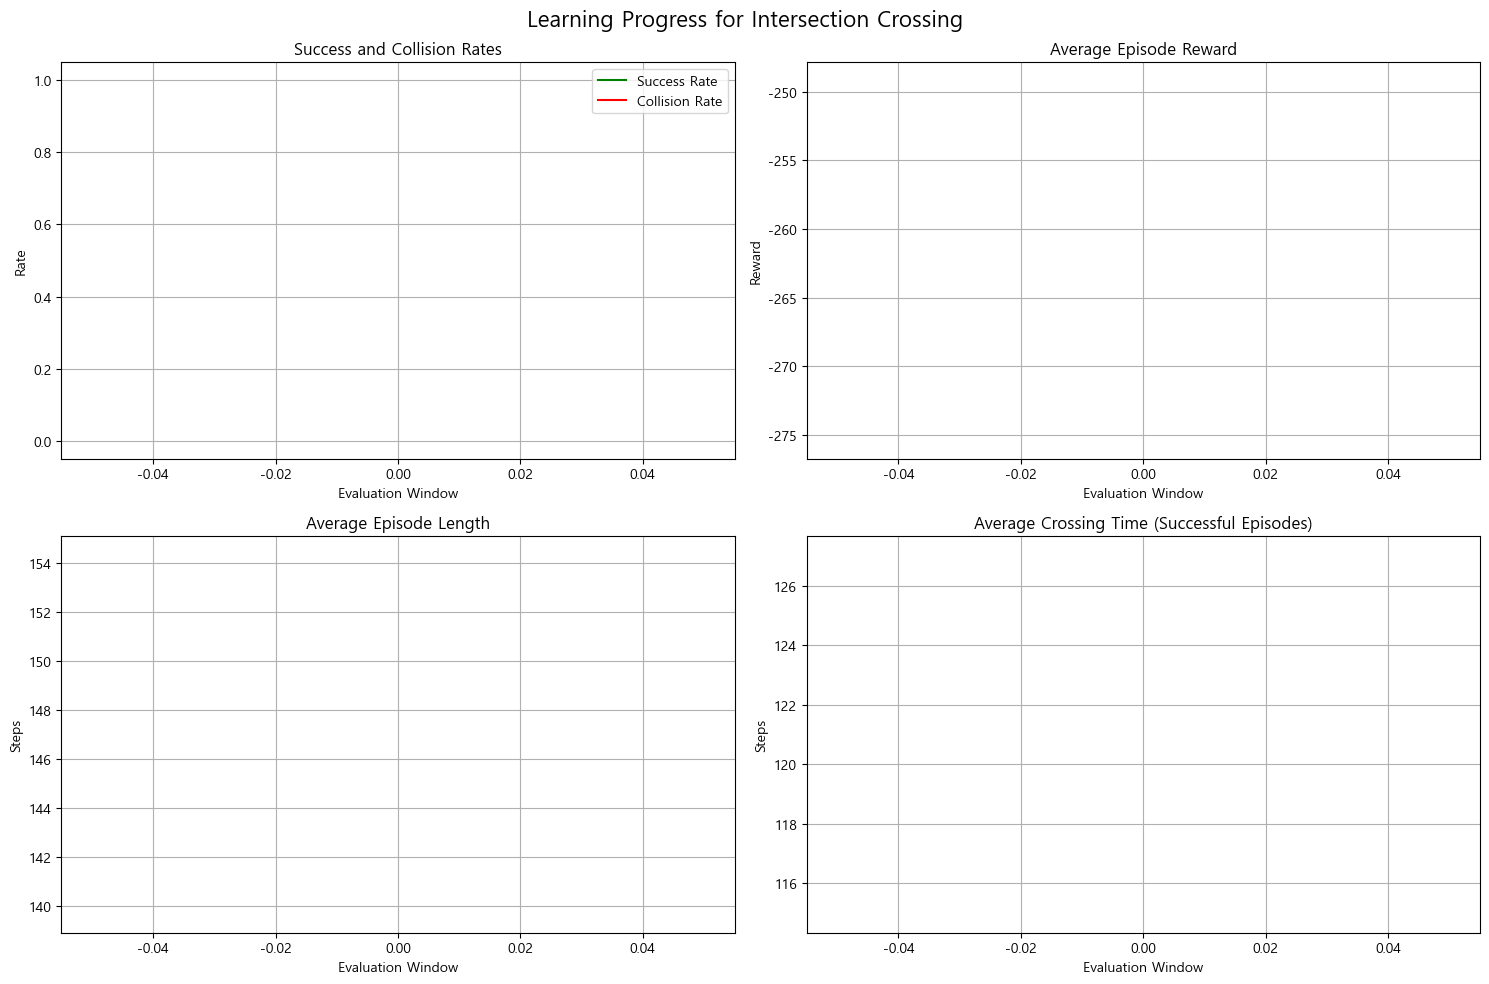

--- Episode 101 Start ---
여긴 ego_vehicle11
Episode done: Reached target point.
Episode 101: Reward = 165.00, Steps = 149
--- Episode 102 Start ---
여긴 ego_vehicle21
Episode done: Reached target point.
Episode 102: Reward = -29.90, Steps = 150
--- Episode 103 Start ---
여긴 ego_vehicle16
Episode 103: Reward = -193.50, Steps = 124
--- Episode 104 Start ---
여긴 ego_vehicle21
Episode done: Reached target point.
Episode 104: Reward = 68.10, Steps = 150
--- Episode 105 Start ---
여긴 ego_vehicle17
Episode done: Reached target point.
Episode 105: Reward = -199.90, Steps = 170
--- Episode 106 Start ---
여긴 ego_vehicle16
Episode done: Reached target point.
Episode 106: Reward = 167.20, Steps = 151
--- Episode 107 Start ---
여긴 ego_vehicle14
Episode done: Reached target point.
Episode 107: Reward = 99.90, Steps = 148
--- Episode 108 Start ---
여긴 ego_vehicle13
Episode done: Reached target point.
Episode 108: Reward = 128.50, Steps = 154
--- Episode 109 Start ---
여긴 ego_vehicle15
Episode 109: Reward = -14

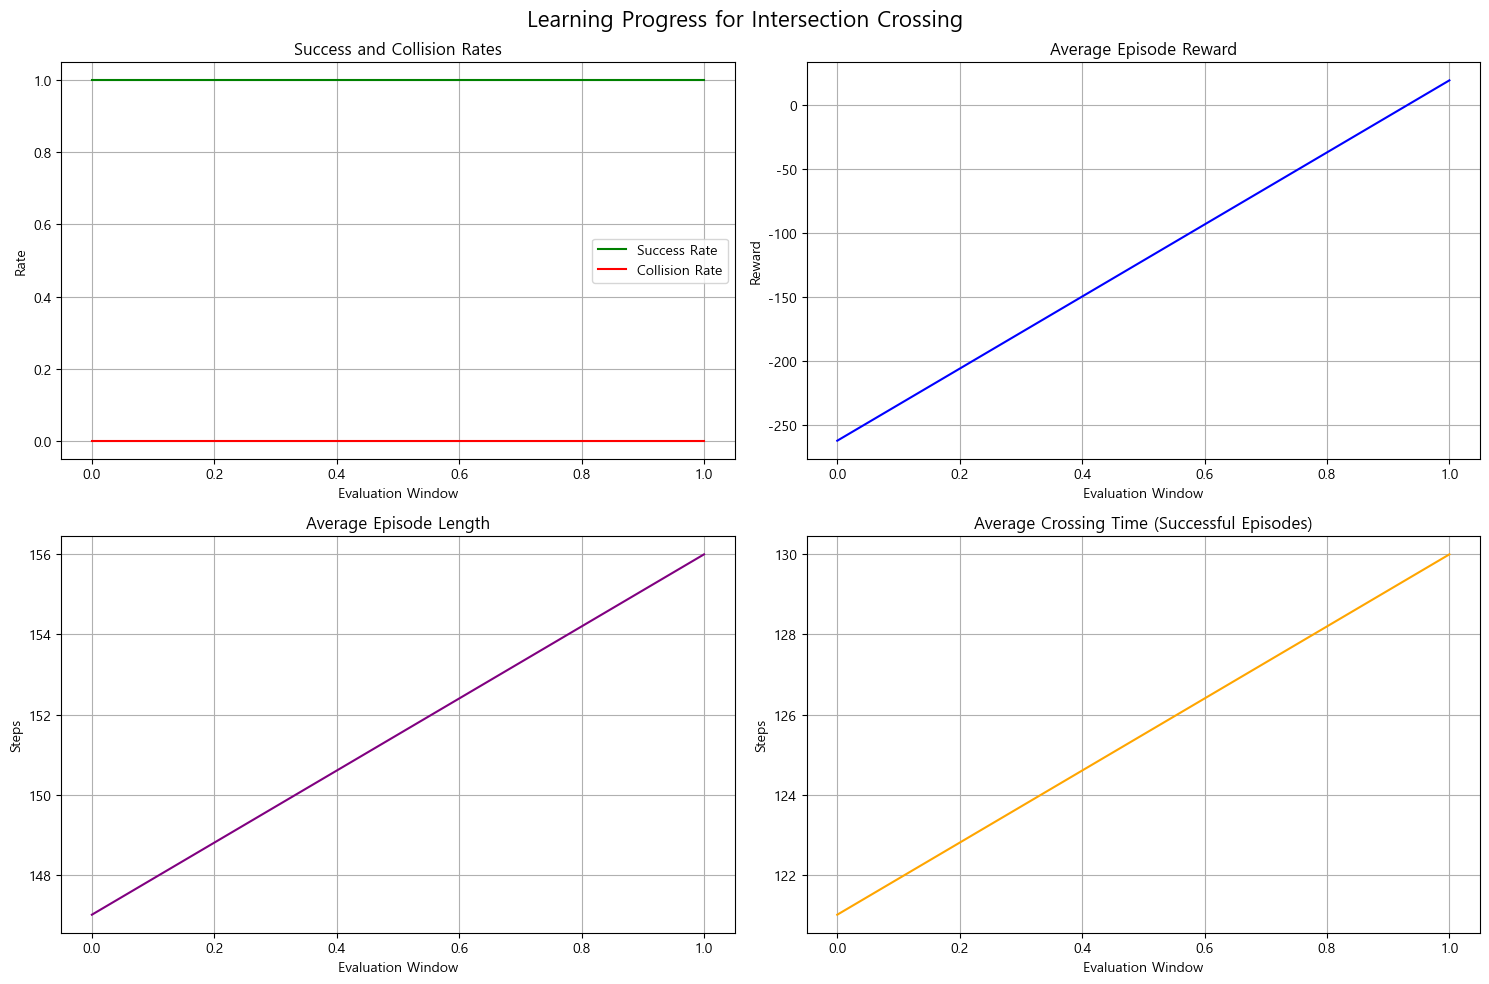

--- Episode 201 Start ---
여긴 ego_vehicle22
Episode done: Reached target point.
Episode 201: Reward = -123.50, Steps = 154
--- Episode 202 Start ---
여긴 ego_vehicle16
Episode 202: Reward = -993.20, Steps = 97
--- Episode 203 Start ---
여긴 ego_vehicle15
Episode done: Reached target point.
Episode 203: Reward = 161.50, Steps = 154
--- Episode 204 Start ---
여긴 ego_vehicle17
Episode done: Reached target point.
Episode 204: Reward = -506.80, Steps = 151
--- Episode 205 Start ---
여긴 ego_vehicle20
Episode done: Reached target point.
Episode 205: Reward = -46.40, Steps = 155
--- Episode 206 Start ---
여긴 ego_vehicle13
Episode done: Reached target point.
Episode 206: Reward = -16.40, Steps = 155
--- Episode 207 Start ---
여긴 ego_vehicle18
Episode 207: Reward = -95.70, Steps = 142
--- Episode 208 Start ---
여긴 ego_vehicle19
Episode done: Reached target point.
Episode 208: Reward = -287.50, Steps = 154
--- Episode 209 Start ---
여긴 ego_vehicle19
Episode done: Reached target point.
Episode 209: Reward = 

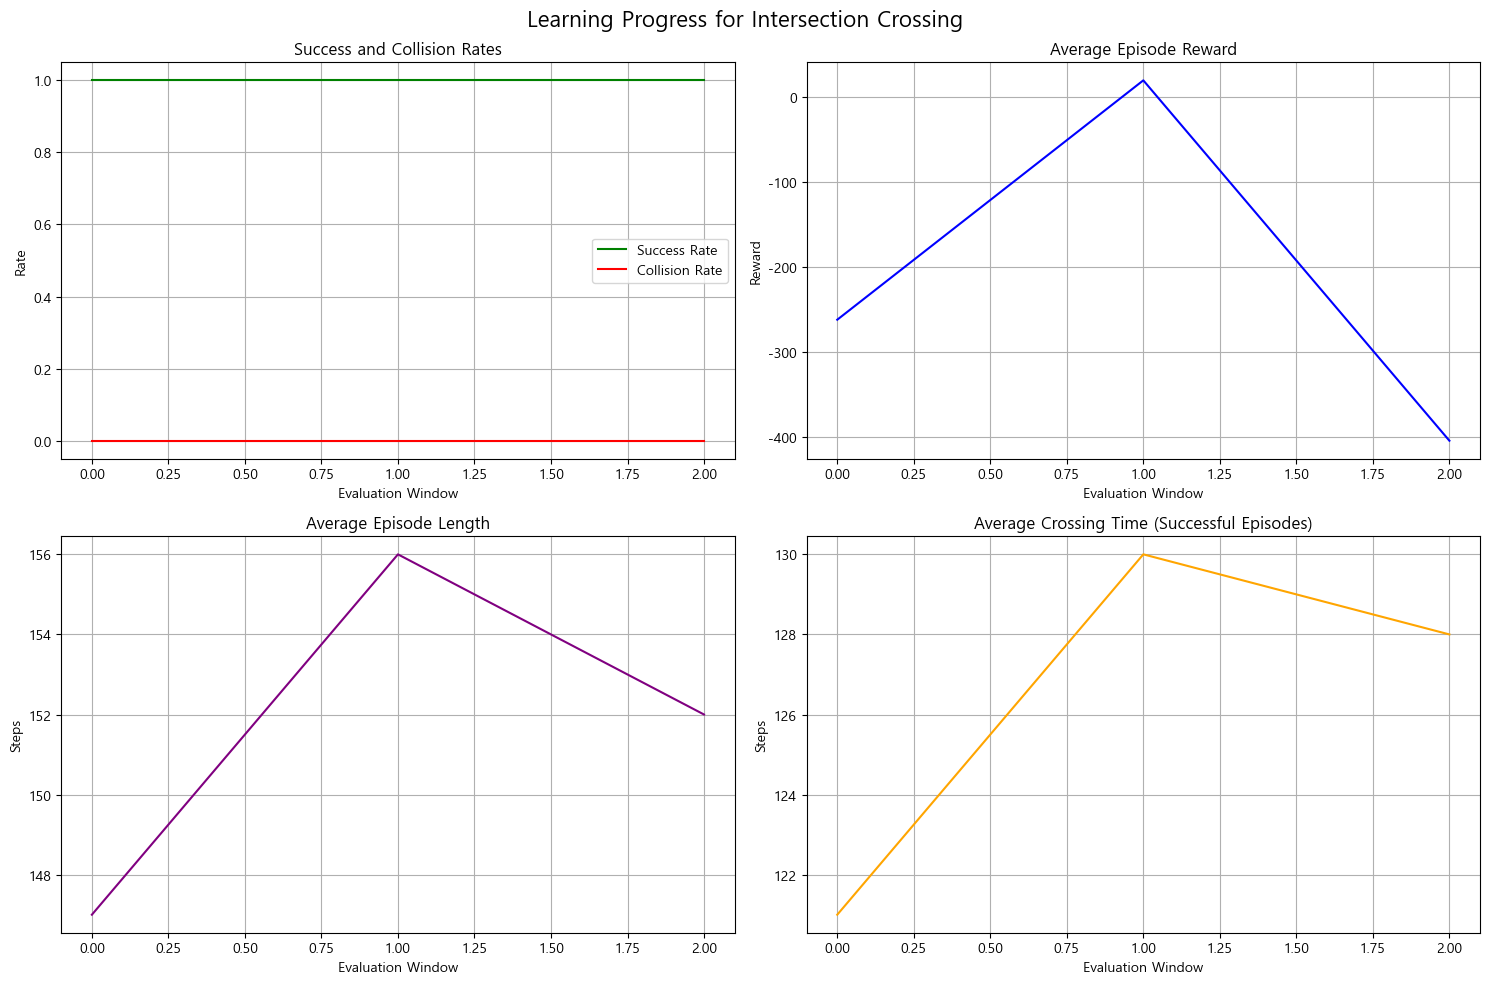

--- Episode 301 Start ---
여긴 ego_vehicle17
Episode done: Reached target point.
Episode 301: Reward = -282.60, Steps = 173
--- Episode 302 Start ---
여긴 ego_vehicle17
Episode done: Reached target point.
Episode 302: Reward = 178.90, Steps = 188
--- Episode 303 Start ---
여긴 ego_vehicle12
Episode done: Reached target point.
Episode 303: Reward = -504.80, Steps = 151
--- Episode 304 Start ---
여긴 ego_vehicle19
Episode 304: Reward = -467.90, Steps = 100
--- Episode 305 Start ---
여긴 ego_vehicle13
Episode done: Reached target point.
Episode 305: Reward = 161.70, Steps = 146
--- Episode 306 Start ---
여긴 ego_vehicle18
Episode done: Reached target point.
Episode 306: Reward = -440.80, Steps = 151
--- Episode 307 Start ---
여긴 ego_vehicle24
Episode done: Reached target point.
Episode 307: Reward = -113.90, Steps = 150
--- Episode 308 Start ---
여긴 ego_vehicle14
Episode done: Reached target point.
Episode 308: Reward = -253.00, Steps = 149
--- Episode 309 Start ---
여긴 ego_vehicle22
Episode done: Reach

In [ ]:
# =========================
# 메인 (TD3로 학습/평가)
# =========================
# mode="train"
def main(mode='train'):
    try:
        Network_Path = 'C:/Users/user/2_VISSIM_network/3_IG_RL/Network/rightTurn/'
        inpx_Name    = 'Signal intersection_v4.inpx'
        layx_Name    = 'Signal intersection_v4.layx'

        Vissim = Network(Network_Path, inpx_Name, layx_Name)
        # if Vissim is None:
        #     return

        # Vissim.Simulation.SetAttValue('SimRes', 1)
        # Vissim.Simulation.SetAttValue('SimPeriod', 3600)
        # Vissim.Simulation.SetAttValue('SimSpeed', 1)

        link_ranges = {1: (10, 30), 2: (100, 150), 3: (10, 30), 4: (100, 150)} # 조정필요

        agent = TD3Agent(
            state_dim=13, 
            act_low=-3.0, 
            act_high=+3.0,
            actor_lr=1.5e-5, 
            critic_lr=1.5e-4,
            gamma=0.99, 
            tau=0.001,
            policy_noise=0.2, 
            noise_clip=0.5,
            policy_delay=2, 
            batch_size=512,
            start_steps=3000, 
            expl_noise=0.2
        )
        monitor = LearningMonitor()
        if mode == 'train':
            n_episodes = 5000
            max_steps  = 2000

            for episode in range(n_episodes):
                try:
                    episode_reward = 0.0
                    step = 0
                    current_episode_data = []
                    print(f"--- Episode {episode + 1} Start ---")

                    vehicles = None
                    for _ in range(3):
                        vehicles = create_vehicles(Vissim, link_ranges)
                        
                        if vehicles:
                            
                            break
                        time.sleep(0.1)
                    if not vehicles:
                        print("Failed to create vehicles. Skipping episode.")
                        continue

                    ego_vehicle = next((v for v in vehicles if v.AttValue('VehType') == '630'), None)
                    print('여긴 ego_vehicle'+str(ego_vehicle.AttValue('No')))
                    ego_num = ego_vehicle.AttValue('No')
                    # 초기 obs/state
                    current_obs = calculate_observations(vehicles, ego_num=ego_num)
                    current_state = get_state(vehicles, current_obs, ego_num=ego_num, simsec=Vissim.Simulation.AttValue('SimSec'))

                    while step < max_steps:
                        try:
                            vehicles = get_valid_vehicles(Vissim)
                            if not vehicles:
                                break

                            ego_vehicle = next((v for v in vehicles if v.AttValue('VehType') == '630'), None)
                            if ego_vehicle is None:
                                break
                            ego_num = ego_vehicle.AttValue('No')
                            # 최신 obs/state 갱신
                            current_obs = calculate_observations(vehicles, ego_num=ego_num)
                            current_state = get_state(vehicles, current_obs, ego_num=ego_num, simsec=Vissim.Simulation.AttValue('SimSec'))

                            # 행동 선택 및 적용
                            acceleration = agent.select_action(current_state, training=True)
                            apply_action(vehicles, Vissim, acceleration)

                            Vissim.Simulation.RunSingleStep()

                            next_vehicles = get_valid_vehicles(Vissim)
                            if not next_vehicles:
                                break

                            next_obs = calculate_observations(next_vehicles, ego_num=ego_num)
                            next_state = get_state(next_vehicles, next_obs, ego_num=ego_num, simsec=Vissim.Simulation.AttValue('SimSec'))

                            reward, done = get_reward(ego_vehicle, next_obs)
                            if is_episode_done(ego_vehicle, next_obs):
                                done = True

                            episode_reward += float(reward)
                            agent.replay_buffer.push(current_state, acceleration, reward, next_state, done)
                            agent.train_step()

                            step_data = {
                                'Step': step + 1,
                                'Action': acceleration,
                                'Reward': float(reward),
                                'Speed': ego_vehicle.AttValue('Speed'),
                                'Position': ego_vehicle.AttValue('Pos'),
                                'Link': ego_vehicle.AttValue('Lane')
                            }
                            current_episode_data.append(step_data)

                            if done:
                                break
                            step += 1
                            time.sleep(0.05)
                        except Exception as e:
                            print(f"Error in step {step}: {str(e)}")
                            break

                    monitor.add_episode_data(current_episode_data)
                    print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {step}")


                    if (episode + 1) % 100 == 0:
                        metrics = monitor.compute_metrics()
                        print("\nPerformance Metrics:")
                        print(f"Success Rate: {metrics['success_rate']:.2%}")
                        print(f"Collision Rate: {metrics['collision_rate']:.2%}")
                        print(f"Avg Episode Length: {metrics['avg_episode_length']:.1f}")
                        print(f"Avg Reward: {metrics['avg_reward']:.1f}")
                        print(f"Avg Crossing Time: {metrics['avg_crossing_time']:.1f}")
                        monitor.plot_learning_curves()
                        monitor.save_metrics(f'output/v4/training_metrics_toy_3_episode_{episode + 1}.csv')
                        agent.save_models(f'models/v4/checkpoint_{episode + 1}')

                except Exception as e:
                    print(f"Error in episode {episode + 1}: {str(e)}")
                    continue

                agent.save_models('models/v4/final')
                monitor.save_metrics('output/v4/final_training_metrics_toy3.csv')


        elif mode == 'evaluate':
            agent.load_models('models/v4/final')

        results_df = evaluate(Vissim, agent, link_ranges)
        results_df.to_csv('output/v4/evaluation_results_v4.csv', index=False)

    except Exception as e:
        print(f"Critical error in main: {str(e)}")
    finally:
        if 'Vissim' in locals():
            try:
                Vissim.Simulation.Stop()
            except:
                pass

if __name__ == "__main__":
    main(mode='train')  # 필요 시 'evaluate'

In [13]:
# net_path = "C:/Users/user/2_VISSIM_network/3_IG_RL/Network/rightTurn/"
# vissim = COM.Dispatch("Vissim.Vissim")
# vissim.LoadNet(net_path + "Signal intersection_v2.inpx")
# vissim.LoadLayout(net_path+"Signal intersection_v2.layx")

# for i in range(1000):
#     vissim.Simulation.RunsingleStep()

# vissim.Simulation.AttValue('SimSec')
# scs = vnet.SignalControllers
# sc = scs.ItemByKey(10)
# vissim.Net.Vehicles.ItemByKey(1).AttValue('Lane')
